In [8]:
# --- 1. Import Library ---
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
nltk.download('stopwords')
from nltk.corpus import stopwords

# --- 2. Load Dataset ---
df = pd.read_csv("/content/drive/MyDrive/PPW/artikel_medium_multitopik_rss.csv")  # sesuaikan path di Colab
print("Jumlah data:", len(df))
print(df.head())

# --- 3. Preprocessing ---
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # hapus karakter non-huruf
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

df["clean_text"] = df["isi"].apply(clean_text)

# --- 4. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["kategori"],
                                                    test_size=0.2, random_state=42, stratify=df["kategori"])

# --- 5. Ubah ke representasi count untuk LDA ---
vectorizer = CountVectorizer(max_features=3000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# --- 6. Latent Dirichlet Allocation (LDA) untuk ekstraksi fitur ---
n_topics = 10  # jumlah topik tersembunyi
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
X_train_lda = lda.fit_transform(X_train_counts)
X_test_lda = lda.transform(X_test_counts)

print("Dimensi hasil LDA:", X_train_lda.shape)

# --- 7. Klasifikasi (Naive Bayes) ---
model = MultinomialNB()
model.fit(X_train_lda, y_train)
y_pred = model.predict(X_test_lda)

# --- 8. Evaluasi ---
print("\n=== HASIL EVALUASI ===")
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- 9. Contoh Prediksi Baru ---
contoh = ["AI helps doctors detect diseases early"]
contoh_counts = vectorizer.transform(contoh)
contoh_lda = lda.transform(contoh_counts)
prediksi = model.predict(contoh_lda)
print("\nContoh Prediksi:", prediksi[0])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Jumlah data: 38
                                               judul  \
0  The Grand Deception: How Religion, Banking and...   
1                    Spanish Classes For 6 Year Olds   
2  Teen Entrepreneur: How to Turn Curiosity into ...   
3                      Sekolah Mengemudi Berkualitas   
4                                                LPU   

                                                 isi  \
0  <div class="medium-feed-item"><p class="medium...   
1  <div class="medium-feed-item"><p class="medium...   
2  <div class="medium-feed-item"><p class="medium...   
3  <div class="medium-feed-item"><p class="medium...   
4  <div class="medium-feed-item"><p class="medium...   

                                                 url   kategori  
0  https://medium.com/@mickeyknoxdidit76/the-gran...  education  
1  https://medium.com/@lifeskilllear/spanish-clas...  education  
2  https://medium.com/@fauzanahamd123/teen-entrep...  education  
3  https://medium.com/@kursusstirmobilprofesio

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
# --- Import Library ---
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# --- Download NLTK Stopwords ---
nltk.download('stopwords')
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# --- 1. Baca Dataset ---
df = pd.read_csv("/content/drive/MyDrive/PPW/artikel_medium_multitopik_rss.csv")
print("Jumlah data:", len(df))
print(df.head())


Jumlah data: 38
                                               judul  \
0  The Grand Deception: How Religion, Banking and...   
1                    Spanish Classes For 6 Year Olds   
2  Teen Entrepreneur: How to Turn Curiosity into ...   
3                      Sekolah Mengemudi Berkualitas   
4                                                LPU   

                                                 isi  \
0  <div class="medium-feed-item"><p class="medium...   
1  <div class="medium-feed-item"><p class="medium...   
2  <div class="medium-feed-item"><p class="medium...   
3  <div class="medium-feed-item"><p class="medium...   
4  <div class="medium-feed-item"><p class="medium...   

                                                 url   kategori  
0  https://medium.com/@mickeyknoxdidit76/the-gran...  education  
1  https://medium.com/@lifeskilllear/spanish-clas...  education  
2  https://medium.com/@fauzanahamd123/teen-entrep...  education  
3  https://medium.com/@kursusstirmobilprofesio

In [16]:
# --- 2. Preprocessing Teks ---
def bersihkan_teks(teks):
    teks = str(teks).lower()                        # ubah ke huruf kecil
    teks = re.sub(r'http\S+|www.\S+', '', teks)     # hapus URL
    teks = re.sub(r'[^a-z\s]', '', teks)            # hapus karakter non-huruf
    teks = " ".join([w for w in teks.split() if w not in stop_words])  # hapus stopword
    return teks

df['clean_text'] = df['isi'].apply(bersihkan_teks)

In [17]:
# --- 3. Ekstraksi Fitur dengan CountVectorizer ---
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
X_counts = vectorizer.fit_transform(df['clean_text'])

In [19]:
# --- 4. LDA untuk Ekstraksi Topik ---
n_topics = 5  # jumlah topik (bisa diubah)
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
X_lda = lda.fit_transform(X_counts)

print("\n✅ LDA selesai. Bentuk matriks fitur:", X_lda.shape)



✅ LDA selesai. Bentuk matriks fitur: (38, 5)


In [20]:
# ---Tampilkan beberapa kata penting dari setiap topik ---
def tampilkan_topik(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopik {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

tampilkan_topik(lda, vectorizer.get_feature_names_out())



Topik 1:
app src width classmediumfeedimagea medium classmediumfeedsnippethow la classmediumfeedsnippetthe health en

Topik 2:
javascript english plain classmediumfeedimagea width src app digital se medium

Topik 3:
medium trump classmediumfeedsnippetsharm elsheikh elsisi university fun start interactive language

Topik 4:
app src width classmediumfeedimagea medium simple en la language se

Topik 5:
level medium plain english app src width classmediumfeedimagea javascript en


In [21]:
# --- 5. Persiapan Data Klasifikasi ---
y = df['kategori']
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)


In [22]:
# --- 6. Klasifikasi (Naive Bayes) ---
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred = model_nb.predict(X_test)



📊 Evaluasi Model:
Akurasi: 0.375

Confusion Matrix:


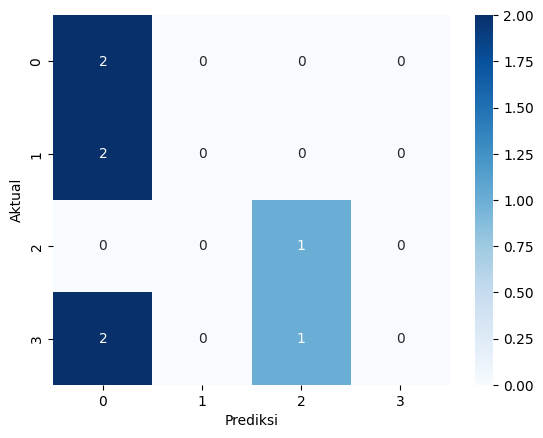


Laporan Klasifikasi:
                  precision    recall  f1-score   support

       education       0.33      1.00      0.50         2
          health       0.00      0.00      0.00         2
machine learning       0.50      1.00      0.67         1
        politics       0.00      0.00      0.00         3

        accuracy                           0.38         8
       macro avg       0.21      0.50      0.29         8
    weighted avg       0.15      0.38      0.21         8



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# --- 7. Evaluasi ---
print("\n📊 Evaluasi Model:")
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred))